In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegressionCV

In [3]:
warnings.filterwarnings("ignore")
sns.set_theme()
sns.set()

Let's import the data.

In [4]:
data_dir = "data.csv"
data = pd.read_csv(data_dir)

How many rows and columns do we have?

In [5]:
data.shape

(108, 7)

Let's get a preview of what the data looks like.

In [6]:
data.head()

,ID,Age,Gender,Height,Weight,BMI,Label
0,1,25,Male,175,80,25.3,Normal Weight
1,2,30,Female,160,60,22.5,Normal Weight
2,3,35,Male,180,90,27.3,Overweight
3,4,40,Female,150,50,20.0,Underweight
4,5,45,Male,190,100,31.2,Obese


How about the data types?

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      108 non-null    int64  
 1   Age     108 non-null    int64  
 2   Gender  108 non-null    object 
 3   Height  108 non-null    int64  
 4   Weight  108 non-null    int64  
 5   BMI     108 non-null    float64
 6   Label   108 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 6.0+ KB


Let's get some statistical information about the data.

In [8]:
data.describe()

,ID,Age,Height,Weight,BMI
count,108.000000,108.000000,108.000000,108.000000,108.000000
mean,56.046296,46.555556,166.574074,59.490741,20.549074
std,31.917939,24.720620,27.873615,28.856233,7.583818
min,1.000000,11.000000,120.000000,10.000000,3.900000
25%,28.750000,27.000000,140.000000,35.000000,16.700000
50%,56.500000,42.500000,175.000000,55.000000,21.200000
75%,83.250000,59.250000,190.000000,85.000000,26.100000
max,110.000000,112.000000,210.000000,120.000000,37.200000


# Data Cleaning

## Remove ID column

In [9]:
data = data.drop(columns=["ID"])
data.head()

,Age,Gender,Height,Weight,BMI,Label
0,25,Male,175,80,25.3,Normal Weight
1,30,Female,160,60,22.5,Normal Weight
2,35,Male,180,90,27.3,Overweight
3,40,Female,150,50,20.0,Underweight
4,45,Male,190,100,31.2,Obese


## Check for null values

If there are any null values in the dataset, we need to deal with them.

In [10]:
data.isnull().sum()

,0
Age,0
Gender,0
Height,0
Weight,0
BMI,0
Label,0


## Check for outliers

In [11]:
len(data.columns)

6

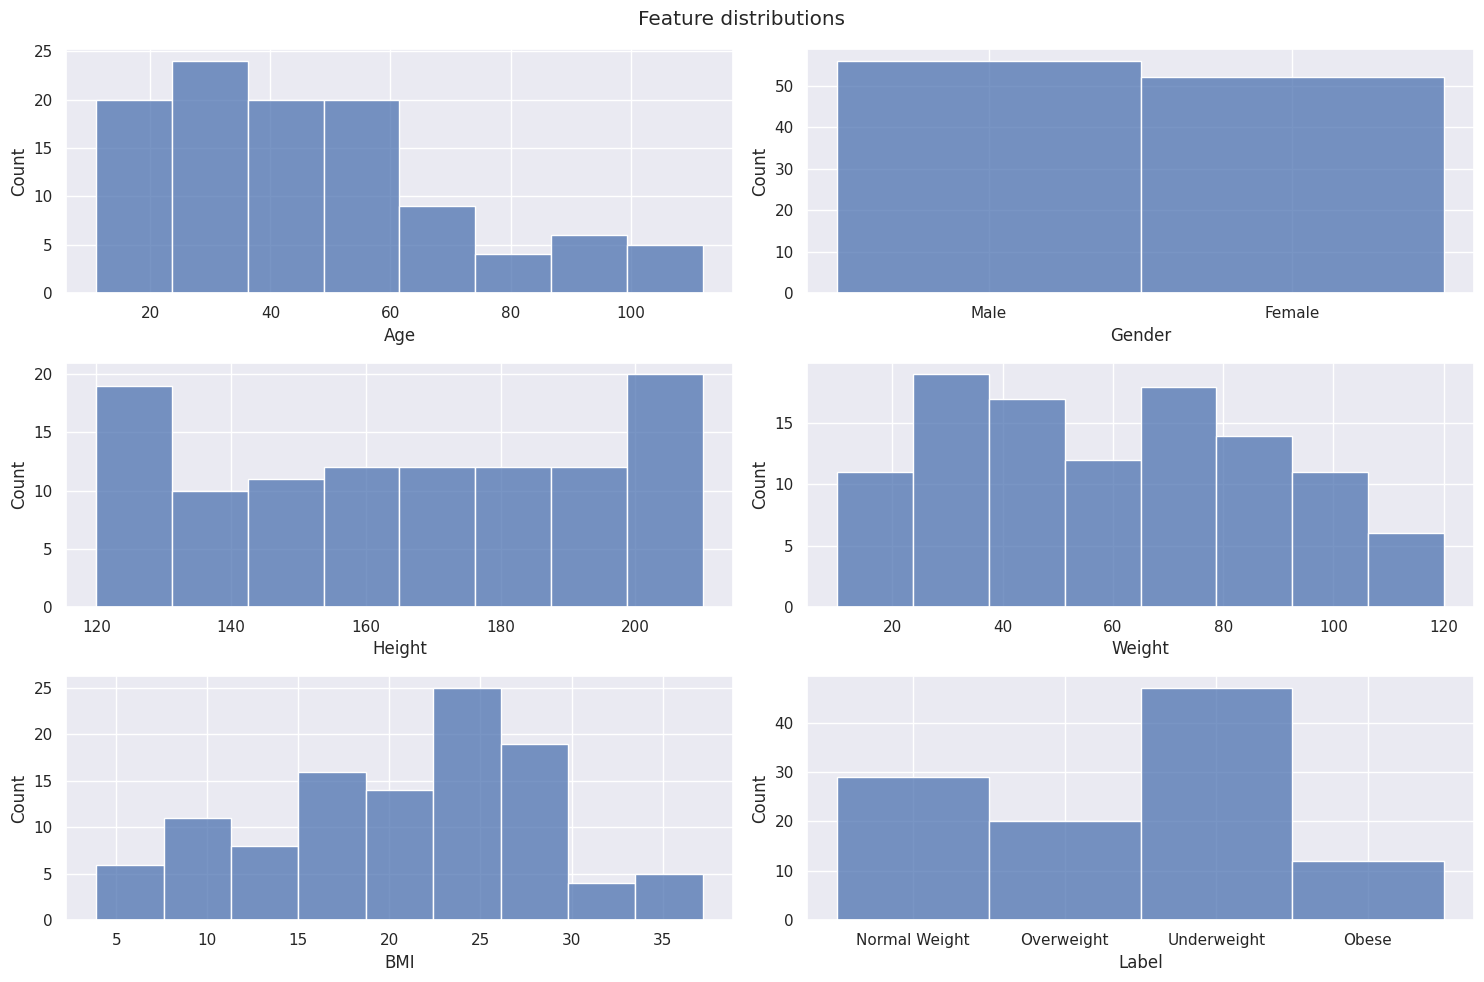

In [12]:
n_rows = 3
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i in range(n_rows):
    for j in range(n_cols):
        feature = data.columns[i*n_cols+j]
        sns.histplot(x=data[feature], ax=axs[i][j])

fig.suptitle("Feature distributions")
fig.tight_layout()
fig.show()

There are no significant outliers.

# EDA

## Pairplot

Pairplots allow us to visualise the relationship between features of the dataset.

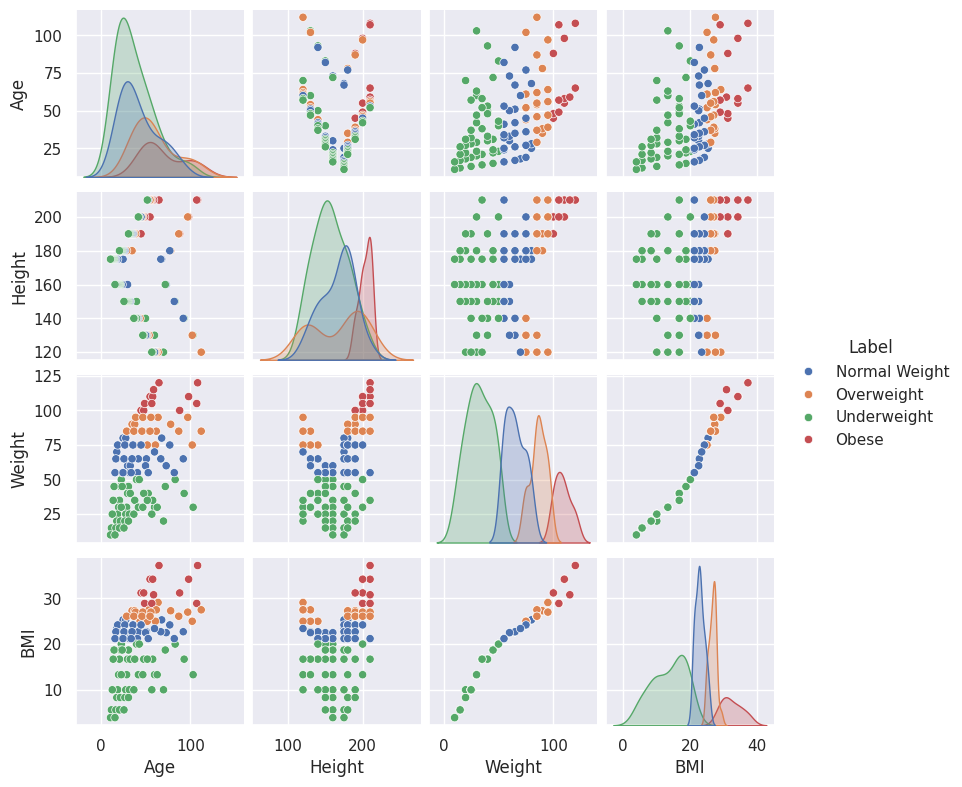

In [13]:
sns.pairplot(data, hue="Label", size=2)
plt.show()

## Effect of Gender on Obesity



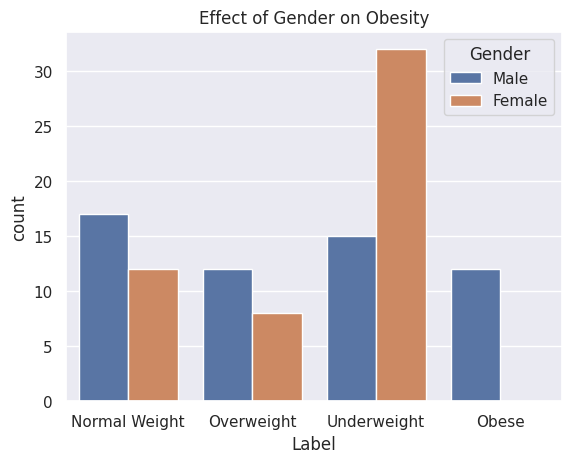

In [14]:
sns.countplot(data=data, x="Label", hue="Gender")
plt.title("Effect of Gender on Obesity")
plt.show()

From this chart we can observe that male individuals have a higher chance of being obese and overweight, while Female individuals have a higher chance of being Underweight.

## Understanding the data

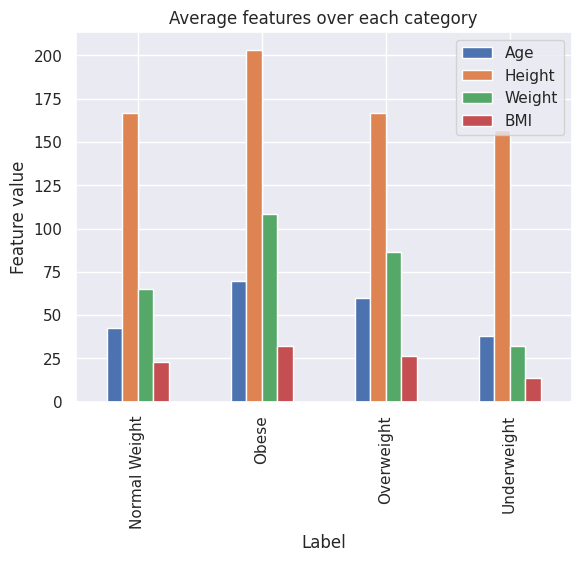

In [15]:
data.groupby("Label")[["Age", "Height", "Weight", "BMI"]].mean().plot(kind="bar")
plt.title("Average features over each category")
plt.ylabel("Feature value")
plt.show()

From this chart we can observe that each feature is, on average, higher for Obese individuals.

This chart shows that on average, older individuals tend to have a higher chance of being obese.

## Correlations

In [16]:
data.head()

,Age,Gender,Height,Weight,BMI,Label
0,25,Male,175,80,25.3,Normal Weight
1,30,Female,160,60,22.5,Normal Weight
2,35,Male,180,90,27.3,Overweight
3,40,Female,150,50,20.0,Underweight
4,45,Male,190,100,31.2,Obese


In [17]:
# convert Gender into binary variable
processed_data = data.copy()
processed_data["Gender"] = LabelEncoder().fit_transform(processed_data["Gender"])

processed_data.head()

,Age,Gender,Height,Weight,BMI,Label
0,25,1,175,80,25.3,Normal Weight
1,30,0,160,60,22.5,Normal Weight
2,35,1,180,90,27.3,Overweight
3,40,0,150,50,20.0,Underweight
4,45,1,190,100,31.2,Obese


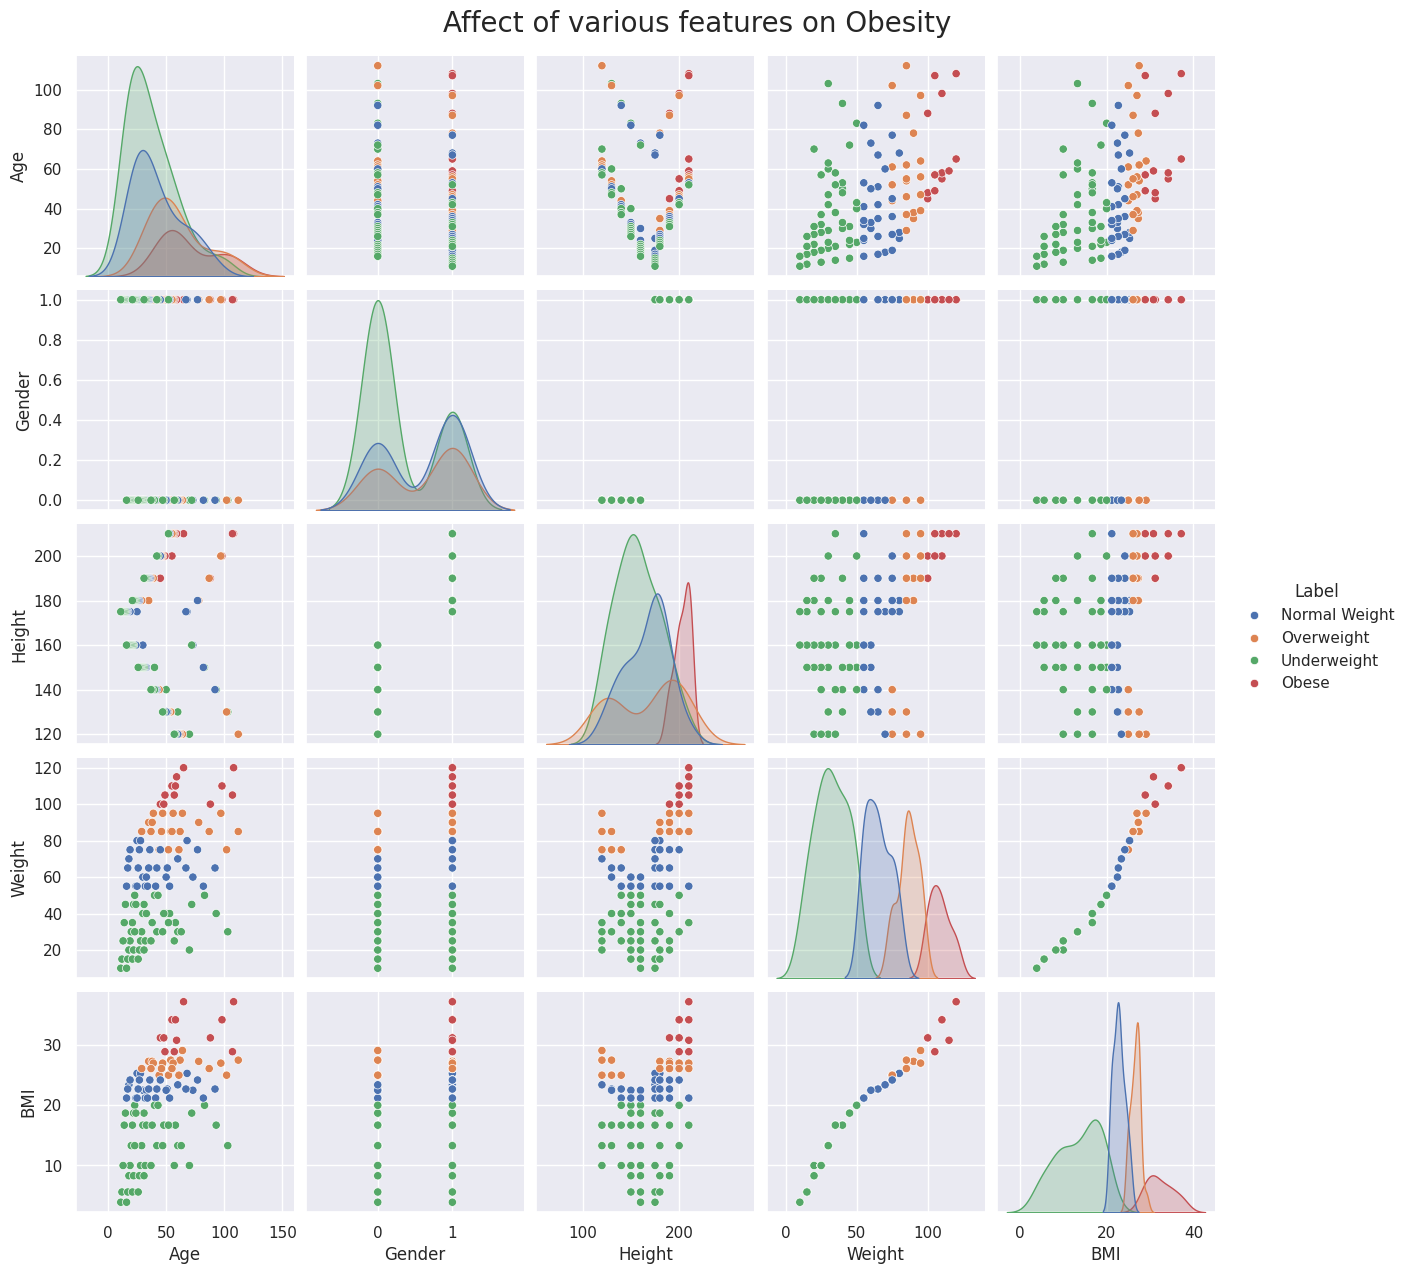

In [18]:
g = sns.pairplot(processed_data, hue="Label")
g.fig.suptitle("Affect of various features on Obesity", y=1.02, fontsize=20)
g.fig.savefig("obesity_pairplot.png")
plt.show()

In [19]:
# map Label to ordinal encoding
label_map = {
    "Underweight": 1,
    "Normal Weight": 2,
    "Overweight": 3,
    "Obese": 4,
}
processed_data = processed_data.replace({"Label": label_map})

processed_data.head()

,Age,Gender,Height,Weight,BMI,Label
0,25,1,175,80,25.3,2
1,30,0,160,60,22.5,2
2,35,1,180,90,27.3,3
3,40,0,150,50,20.0,1
4,45,1,190,100,31.2,4


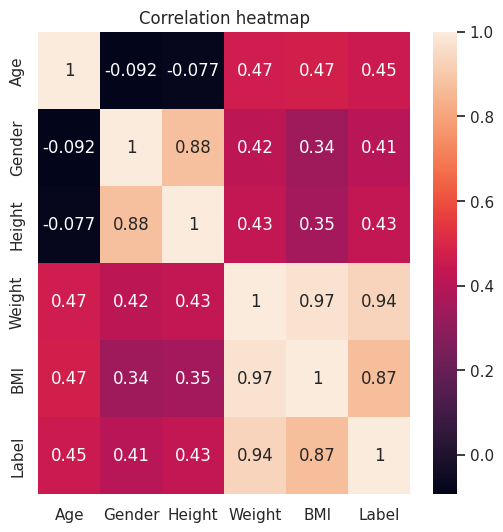

In [20]:
plt.figure(figsize=(6, 6))
sns.heatmap(processed_data.corr(), annot=True)
plt.title("Correlation heatmap")
plt.show()

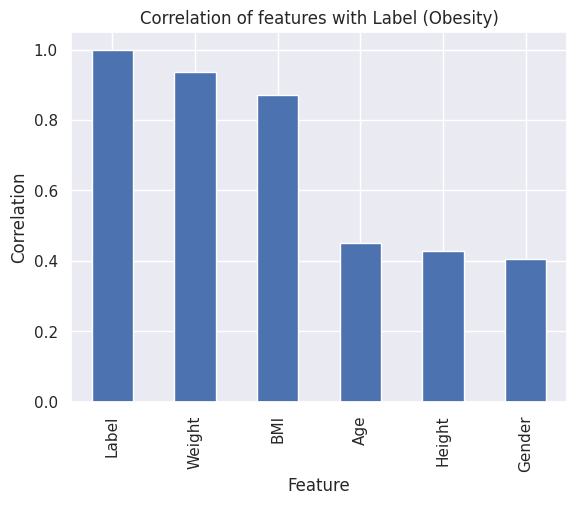

In [21]:
target_corr = processed_data.corr()["Label"]
target_corr = target_corr.sort_values(ascending=False)
target_corr.plot(kind="bar")
plt.xlabel("Feature")
plt.ylabel("Correlation")
plt.title("Correlation of features with Label (Obesity)")
plt.show()

Weight and BMI are strongly positively correlated with Obesity. As Weight and BMI increase, the probability that the individual is Obese also increases.